In order to run this notebook, you have to have a set of curated CS2 data in the folder cs2_curated.

For a cheat sheet how to use autogluon, see here: https://raw.githubusercontent.com/Innixma/autogluon-doc-utils/main/docs/cheatsheets/stable/autogluon-cheat-sheet.jpeg .

In [1]:
import numpy as np
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor

In [2]:
ROUND_IN_PROGRESS_ONLY = True

In [3]:
df = pd.read_csv('cs2_curated/cs2_curated.csv.zip', compression='gzip', low_memory=False)

# Some heavy feature engineering:

# There are map names which start with a capital letter.
df.map_name = df.map_name.apply(str.lower)

# Make sure the round nr is an int:
df.round_nr = df.round_nr.astype(int)

# mark switch rounds: consider each round a switch round where the terrorist rating changes
# we do not care if this is a correct switch or not, if the teams change in the next round, we do not want to predict the next round
rwise = df.groupby('round_id').first().sort_values(by=['map_id', 'round_nr'])
for i in range(1, 4):
    rwise[f'switch_in_{i}'] = 13 - df.round_nr - i
df = df.merge(rwise[[f'switch_in_{i}' for i in range(1, 4)]], left_on='round_id', right_index=True)
total_rounds = df.groupby('map_id').round_nr.max()
total_rounds.name = 'total_rounds'
df = df.merge(total_rounds, left_on='map_id', right_index=True)

# Create the round winner lookups for the current and the next rounds.
# The result will be a table with the round_ids as indices and the round_winners as columns.
# E.g. round_winner_3 is the round winner three rounds from the current round, so if the current round is 10, then it would be round 13.
# This calculation only takes rounds which actually exist, so on columns after the match ends.
round_winner_table = df.groupby(['map_id', 'round_nr']).round_winner.last().dropna().astype(int).to_frame().rename(columns={'round_winner': 'round_winner_0'})

# For each horizon, join the round winner lookup with the shifted array. Note that we don't convert to int yet, as we can't; the rows will contain NaN:
for horizon in range(1, 4):
    round_winner_table = round_winner_table.join(
        round_winner_table.groupby(['map_id', 'round_nr'])['round_winner_0'].first().shift(-horizon).rename(f'round_winner_{horizon}')
    )

# Merge the round-winner-table back into the main dataframe and rename the columns while on the way:
df = df.merge(round_winner_table, left_on=['map_id', 'round_nr'], right_index=True, copy=False, validate='m:1')

In [4]:
# We do not want to do predictions into overtime or after round switch, which means we have to invalidate targets with a horizon in overtime:
# - All t_win_next(i) or target_i for round = 24, 12
# - All t_win_next(i) or target_i for i in (2, 3) for round = 23, 11
# - All t_win_next(i) or target_i for i in (3) for round = 22, 10
df.loc[df.round_nr == df.max_regular_rounds, 'round_winner_1'] = pd.NA
df.loc[df.round_nr == df.max_regular_rounds, 'round_winner_2'] = pd.NA
df.loc[df.round_nr == df.max_regular_rounds, 'round_winner_3'] = pd.NA
df.loc[df.round_nr == df.max_regular_rounds - 1, 'round_winner_2'] = pd.NA
df.loc[df.round_nr == df.max_regular_rounds - 1, 'round_winner_3'] = pd.NA
df.loc[df.round_nr == df.max_regular_rounds - 2, 'round_winner_3'] = pd.NA
df.loc[df.round_nr == df.max_regular_rounds / 2, 'round_winner_1'] = pd.NA
df.loc[df.round_nr == df.max_regular_rounds / 2, 'round_winner_2'] = pd.NA
df.loc[df.round_nr == df.max_regular_rounds / 2, 'round_winner_3'] = pd.NA
df.loc[df.round_nr == df.max_regular_rounds / 2 - 1, 'round_winner_2'] = pd.NA
df.loc[df.round_nr == df.max_regular_rounds / 2 - 1, 'round_winner_3'] = pd.NA
df.loc[df.round_nr == df.max_regular_rounds / 2 - 2, 'round_winner_3'] = pd.NA

# Disabled, since the curated set does not have switch_in_1 set:
#df.loc[df.switch_in_1, 'round_winner_1'] = pd.NA
#df.loc[df.switch_in_1, 'round_winner_2'] = pd.NA
#df.loc[df.switch_in_1, 'round_winner_3'] = pd.NA
#df.loc[df.switch_in_2, 'round_winner_2'] = pd.NA
#df.loc[df.switch_in_2, 'round_winner_3'] = pd.NA
#df.loc[df.switch_in_3, 'round_winner_3'] = pd.NA

In [5]:
# Create the target columns for this and the following rounds:
df['target_0'] = df['round_winner_0'].astype(int)
for k in range(1, 4):
    df[f'target_{k}'] = df[f'round_winner_{k}']

# Add fields indicating pistol rounds, the score difference and dominance, bin the pts and add an indicator whether it is a high-eco-sample(!) / in overtime:
df = df.assign(
    is_pistol_round = (df.round_nr == 1).astype(int) + (df.round_nr == df.max_regular_rounds // 2 + 1).astype(int),
    is_pistol_round_1 = (df.round_nr == df.max_regular_rounds // 2).astype(int),
    score_diff = df.t_round_score - df.ct_round_score,
    score_dominance = df.t_round_score / (df.t_round_score + df.ct_round_score),
    is_high_eco = (df.t_eq > 25_000) & (df.ct_eq > 25_000),
    is_overtime = df.round_nr > df.max_regular_rounds,
    t_pts_bin = pd.cut(df.t_pts, bins=np.linspace(0, 1.0, 21, endpoint=True)),
    t_pot = df.t_cash + df.t_eq,
    ct_pot = df.ct_cash + df.ct_eq,
)
df.score_dominance = df.score_dominance.fillna(0.5)

# Finally, we are only interested in real events, not that stupid round-start event which indicates the start of the buying phase.
df = df[df.event_type != 'round_start']

In [6]:
# Add the average death count to the mix:
for k in range(5):
    df[f't_p{k}_death_stat'] = df[f't_p{k}_deaths'] / df.round_nr
    df[f'ct_p{k}_death_stat'] = df[f'ct_p{k}_deaths'] / df.round_nr

In [7]:
features = ['map_name', 't_cash', 'ct_cash', 't_alive', 'ct_alive',
    't_eq', 'ct_eq', 't_losing_streak', 'ct_losing_streak', 
    'bomb_is_planted', 'bomb_is_defused', 't_pts', 'score_diff', 'score_dominance', 'round_winner']
features += [c for c in df if 'health' in c]
features += [c for c in df if 'death_stat' in c]

In [8]:
# Make a train test split:
if ROUND_IN_PROGRESS_ONLY:
    df_train = df[:int(0.8 * len(df))].query('round_in_progress == True')[features]
    df_test = df[int(0.8 * len(df)):].query('round_in_progress == True')[features]

else:
    df_train = df[:int(0.8 * len(df))][features]
    df_test = df[int(0.8 * len(df)):][features]

train_data = TabularDataset(df_train)
test_data = TabularDataset(df_test)

In [9]:
predictor = TabularPredictor(label='round_winner').fit(train_data, tuning_data=test_data, presets='best_quality', use_bag_holdout=True)

No path specified. Models will be saved in: "AutogluonModels/ag-20241219_134307"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.2
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #136-Ubuntu SMP Wed Nov 6 10:38:22 UTC 2024
CPU Count:          8
Memory Avail:       12.64 GB / 23.10 GB (54.7%)
Disk Space Avail:   311.50 GB / 937.33 GB (33.2%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "/home/notger/projects/motley_crew_of_models/autogluon_experiments/AutogluonModels/ag-20241219_134307"
Train Data Rows:    377637
Train Data Columns: 34
Tuning Data Rows:    93135
Tuning Data Columns: 34
L

In [10]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.798744,accuracy,81.321464,121.415456,0.005183,0.489272,2,True,5
1,WeightedEnsemble_L3,0.798744,accuracy,81.321480,121.520191,0.005200,0.594008,3,True,7
2,LightGBM_BAG_L1,0.797810,accuracy,15.853575,120.543189,15.853575,120.543189,1,True,4
3,LightGBMXT_BAG_L1,0.791217,accuracy,284.264769,815.975593,284.264769,815.975593,1,True,3
4,LightGBMXT_BAG_L2,0.760670,accuracy,706.222740,1870.005610,275.229925,932.697837,2,True,6
5,KNeighborsUnif_BAG_L1,0.749707,accuracy,65.462705,0.382995,65.462705,0.382995,1,True,1
6,KNeighborsDist_BAG_L1,0.747796,accuracy,65.411765,0.405996,65.411765,0.405996,1,True,2


In [11]:
predictor.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                   model  score_val eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0    WeightedEnsemble_L2   0.798744    accuracy      81.321464   121.415456                0.005183           0.489272            2       True          5
1    WeightedEnsemble_L3   0.798744    accuracy      81.321480   121.520191                0.005200           0.594008            3       True          7
2        LightGBM_BAG_L1   0.797810    accuracy      15.853575   120.543189               15.853575         120.543189            1       True          4
3      LightGBMXT_BAG_L1   0.791217    accuracy     284.264769   815.975593              284.264769         815.975593            1       True          3
4      LightGBMXT_BAG_L2   0.760670    accuracy     706.222740  1870.005610              275.229925         932.697837            2       True          6
5  KNeighborsU

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': 0.7497074139689698,
  'KNeighborsDist_BAG_L1': 0.7477962098029742,
  'LightGBMXT_BAG_L1': 0.7912170505180651,
  'LightGBM_BAG_L1': 0.7978096311805444,
  'WeightedEnsemble_L2': 0.7987437590594298,
  'LightGBMXT_BAG_L2': 0.760669995168304,
  'WeightedEnsemble_L3': 0.7987437590594298},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'KNeighborsUnif_BAG_L1': ['KNeighborsUnif_BAG_L1'],
  'KNeighborsDist_BAG_L1': ['KNeighborsDist_BAG_L1'],
  'LightGBMXT_BAG_L1': ['LightGBMXT_BAG_L1'],
  'LightGBM_BAG_L1': ['LightGBM_BAG_L1'],
  'WeightedEnsemble_L2': ['WeightedEnsembl

In [12]:
predictor.feature_importance(test_data)

Computing feature importance via permutation shuffling for 34 features using 5000 rows with 5 shuffle sets...


Wird in einer aktuellen Browsersitzung geöffnet.


	744.8s	= Expected runtime (148.96s per shuffle set)
	694.01s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
t_eq,0.06376,0.004330,0.000003,5,0.072675,0.054845
t_alive,0.05504,0.005149,0.000009,5,0.065641,0.044439
ct_alive,0.04904,0.006725,0.000041,5,0.062887,0.035193
ct_eq,0.04792,0.006102,0.000031,5,0.060484,0.035356
bomb_is_planted,0.00540,0.002757,0.005938,5,0.011076,-0.000276
score_dominance,0.00344,0.001699,0.005304,5,0.006939,-0.000059
t_p4_health,0.00332,0.002300,0.016032,5,0.008057,-0.001417
t_pts,0.00300,0.001924,0.012591,5,0.006961,-0.000961
t_p3_health,0.00240,0.003253,0.087156,5,0.009097,-0.004297
ct_p2_health,0.00232,0.002143,0.036347,5,0.006732,-0.002092


In [13]:
predictor.evaluate(test_data)

{'accuracy': 0.7987867074676545,
 'balanced_accuracy': 0.7987336196985558,
 'mcc': 0.5974852561746028,
 'roc_auc': 0.88796703741857,
 'f1': 0.8017476673084654,
 'precision': 0.8009511731135066,
 'recall': 0.8025457472043375}

In [14]:
# Plot the ECE:
df_plot = df_test[['round_winner']].astype(int).copy()
df_plot = df_plot.assign(
    yp = predictor.predict_proba(test_data)[True],
    yp_bin = lambda df_plot: pd.cut(df_plot.yp, bins=np.linspace(0, 1.0, 21, endpoint=True))
)

In [15]:
# Calculate the Brier score:
((df_plot.round_winner - df_plot.yp) ** 2).mean()

0.13642121773148533

without health features: 0.1369

with health features: 0.1349

Our models: 0.11something

/tmp/ipykernel_108509/44786274.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot.groupby('yp_bin').mean().plot()


<Axes: xlabel='yp_bin'>

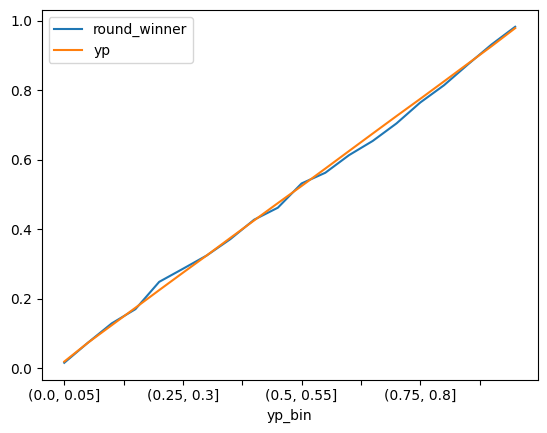

In [16]:
df_plot.groupby('yp_bin').mean().plot()